In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np

In [3]:
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/black_bear
oregon_wildlife/cougar
oregon_wildlife/red_fox
oregon_wildlife/raven
oregon_wildlife/bald_eagle
oregon_wildlife/raccoon
oregon_wildlife/nutria
oregon_wildlife/virginia_opossum
oregon_wildlife/deer
oregon_wildlife/sea_lions

total img num: 7168


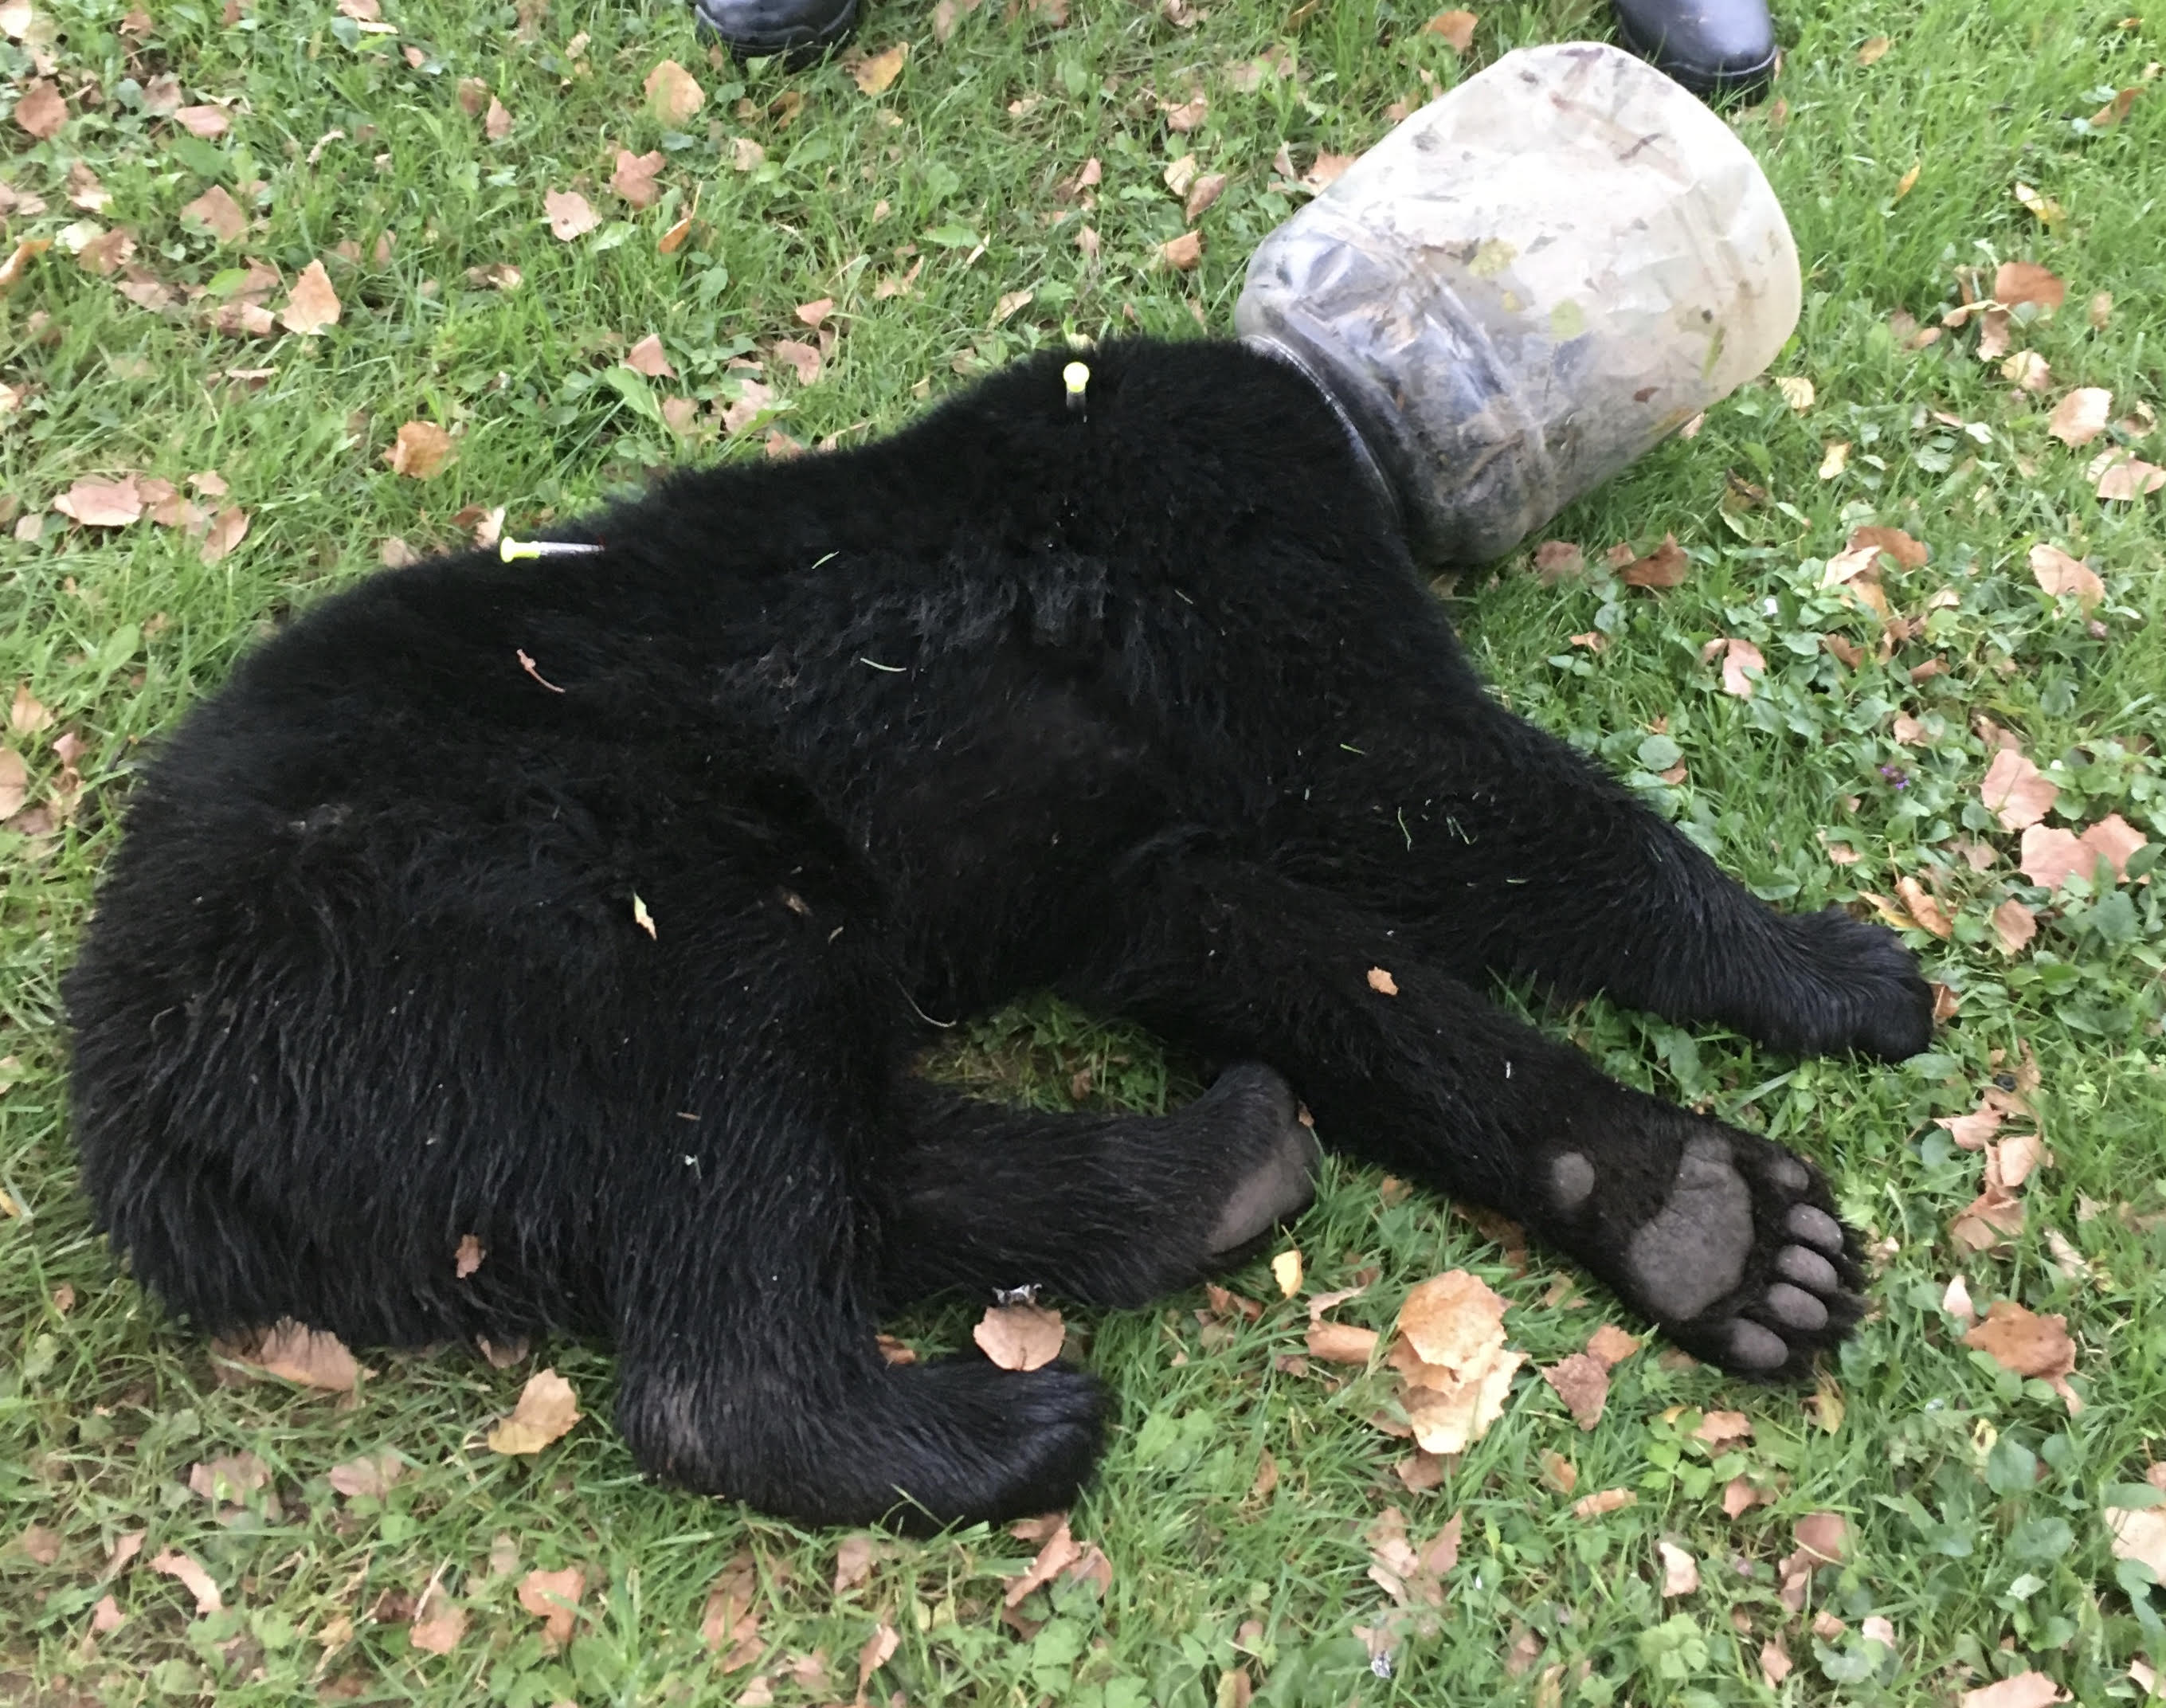

black_bear


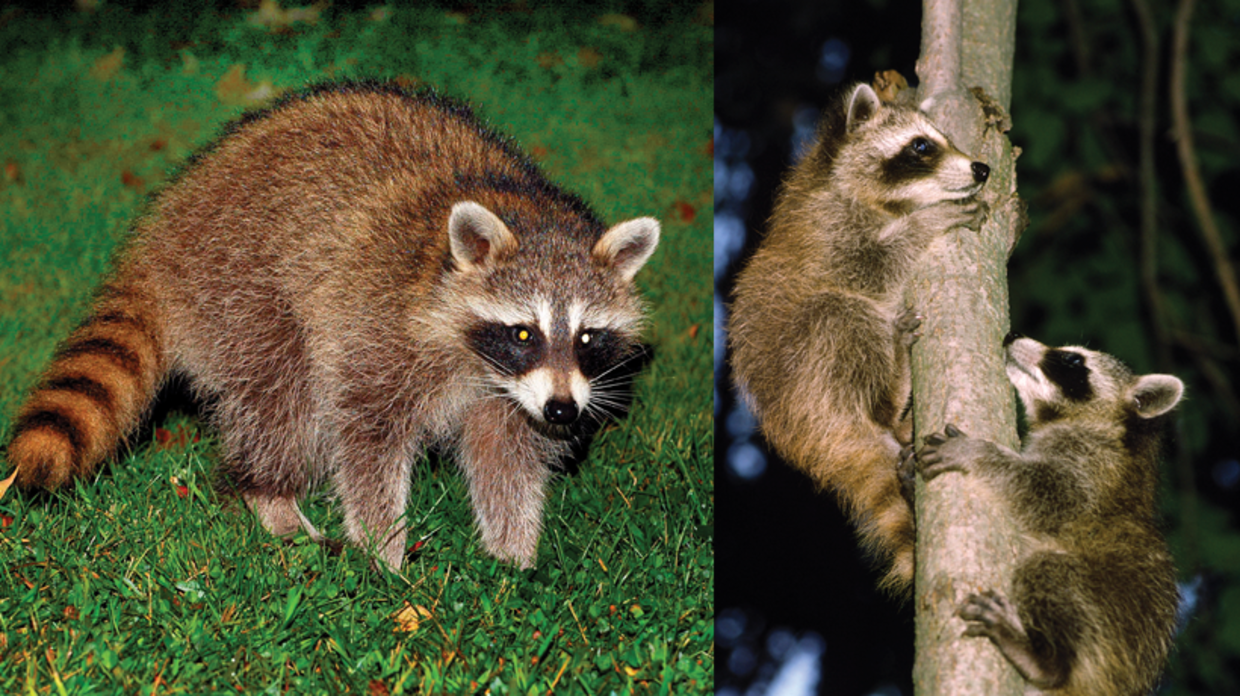

raccoon


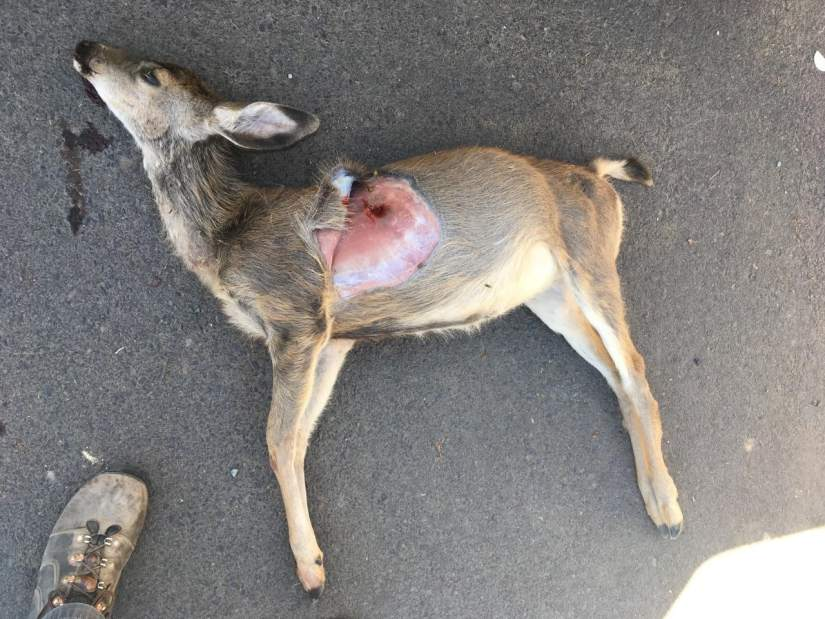

deer


In [4]:
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [5]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [3, 5, 7, 5, 2, 7, 2, 1, 2, 1]


In [8]:
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [9]:
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3


# feel free to modify these Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [10]:
def load_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img, label

In [11]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [12]:
def serialize_example(img, label):
    # Create a dictionary mapping the feature name to the tf.Example-compatible data type.
    feature = {
        'img': _bytes_feature(img.numpy().tobytes()),
        'label': _int64_feature(label)
    }

    # Create a Features message using tf.train.Example.
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    
    return example_proto.SerializeToString()

In [13]:
def tf_serialize_example(img, label):
    tf_string = tf.py_function(
        serialize_example,
        (img, label),  # pass these args to the above function.
        tf.string)      # the return type is `tf.string`.
    return tf.reshape(tf_string, ()) # The result is a scalar

In [14]:
serialized_dataset_train = tf.data.Dataset.from_tensor_slices((img_path_train,label_train)).map(load_image).map(tf_serialize_example)
serialized_dataset_val = tf.data.Dataset.from_tensor_slices((img_path_val,label_val)).map(load_image).map(tf_serialize_example)

In [15]:
# Write data here
filename_train = 'lab12_train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename_train)
writer.write(serialized_dataset_train)

filename_val = 'lab12_val.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename_val)
writer.write(serialized_dataset_val)

In [16]:
# Load data here
filenames = ['lab12_train.tfrecord']
raw_dataset_train = tf.data.TFRecordDataset(filenames)
filenames = ['lab12_val.tfrecord']
raw_dataset_val = tf.data.TFRecordDataset(filenames)

In [17]:
# Create a description of the features.
feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.int64, default_value=0),
}

def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

parsed_dataset_train = raw_dataset_train.map(_parse_function)
parsed_dataset_val = raw_dataset_val.map(_parse_function)

In [18]:
def to_numpy(img, label):
    img = np.fromstring(img.numpy(), np.float32).reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)
    return img, label

def tf_to_numpy(input_data):
    tf_np, label = tf.py_function(to_numpy, (input_data['img'], input_data['label']), (tf.float32, tf.int64))
    return tf_np, tf.reshape(label, ())

parsed_dataset_train_in_np = parsed_dataset_train.map(tf_to_numpy)
parsed_dataset_val_in_np = parsed_dataset_val.map(tf_to_numpy)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [19]:
# parse training data
def map_fun(image, label):
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(image,label):
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [20]:
# Construct training Dataset
dataset_train_final_data = parsed_dataset_train_in_np.map(map_fun).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Construct testing Dataset
dataset_val_t_final_data = parsed_dataset_val_in_np.map(map_fun_test).batch(BATCH_SIZE)

/home/haowei/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


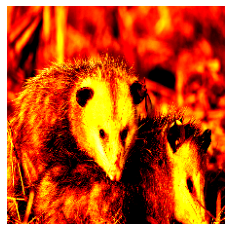

virginia_opossum


In [21]:
# show one image here.
for img, label in dataset_train_final_data.take(1):
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [22]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [69]:
wild_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

wild_model.fit(dataset_train_final_data, validation_data=dataset_val_t_final_data, epochs=5)

Epoch 1/5


/home/haowei/miniconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


180/180 [==============================] - 30s 103ms/step - loss: 5.8188 - accuracy: 0.3942 - val_loss: 0.4036 - val_accuracy: 0.8745
Epoch 2/5
180/180 [==============================] - 28s 98ms/step - loss: 0.7561 - accuracy: 0.7648 - val_loss: 0.3167 - val_accuracy: 0.8989
Epoch 3/5
180/180 [==============================] - 28s 101ms/step - loss: 0.6301 - accuracy: 0.8050 - val_loss: 0.2898 - val_accuracy: 0.9079
Epoch 4/5
180/180 [==============================] - 26s 100ms/step - loss: 0.5389 - accuracy: 0.8337 - val_loss: 0.2536 - val_accuracy: 0.9212
Epoch 5/5
180/180 [==============================] - 29s 102ms/step - loss: 0.4764 - accuracy: 0.8529 - val_loss: 0.2330 - val_accuracy: 0.9344
